# Herramientas para hacer Fast Fourier Transform Directo

En este cuaderno de Julia indicamos un posible uso de las herramientas desarrolladas por el Dr. WPK Zapfe para la transformada rápida de Fourier en linea de los datos de BioCAM X. Estamos usando ad hoc un par de modulos auxiliares que nos permiten abrir los archivos tal y como vienen en el flujo (hexadecimal sin signo), interpretarlos y aplicarles una fftw.
La libreria fftw  ("Fastest Fourier Transform in the West" [fftw.org](www.fftw.org)  ) es el paradigma y canon de las transformadas de Fourier rápida. Existen interfaces para [c++](http://www.fftw.org/download.html) y [python](https://github.com/pyFFTW/pyFFTW). 

In [3]:
push!(LOAD_PATH, ".") # las herramientas para hacer fftw estan aqui
push!(LOAD_PATH, "../Preprocesamiento/") # el interpretador de los datos crudos esta aqui
using PreprocTools #para abrir y manejar los datos crudos
using FFTWtoolkit, FFTW # the fastest fourier transform in the west
using PyPlot # posible graficador, se pueden usar otros

┌ Info: Precompiling FFTWtoolkit [top-level]
└ @ Base loading.jl:1260


In [4]:
abrestring="/home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw"


"/home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw"

En la versión en linea, los datos que aparecen catalogados en el siguiente diccionario deben de estar detallados en algun objeto visible de python. De aquí los interesantes son minvolt, maxvolt, bithdept e inversión, de los que se obtiene el factor de conversión según la siguiente formula
$$
(maxvolt-minvolt)/2^(bitdepth)*inversion=factor
$$
Y también nos interesa la frecuencia de muestreo. El número de cuadros máximo no tiene sentido en el trabajo en linea, ese se va a obtener por la convenciencia del usuario, pero para una buena fftw unos 1000 cuadros son adecuados.

In [5]:
Datos=AbreyCheca(abrestring)

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 370 in H5Fis_hdf5(): unable open file
    major: File accessibilty
    minor: Not an HDF5 file
  #001: H5Fint.c line 802 in H5F__is_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #002: H5FD.c line 734 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDsec2.c line 346 in H5FD_sec2_open(): unable to open file: name = '/home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw', errno = 2, error message = 'No existe el fichero o el directorio', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file /home/karel/BRWFiles/Facilitada/19115s1cut_single_event.brw

Las siguientes constantes nos daran las unidades adecuadas para trabajar.

In [15]:
freq=Datos["frecuencia"]
factor=Datos["factor"]

2.01416015625

Esta es una función de conveniencia para escoger el canal. En la versión en linea usar el ratón de la computadora sobre la representación visual del MEA puede ser más conveniente.

In [16]:
escogecanal(y::Int,x::Int)=(y-1)*64+x

escogecanal (generic function with 1 method)

Se le preguntará al usuario cuanto en tiempo quiere transformar a la Fourier. El usuario especificará un rango de tiempo (típicamente entre 0.1 y 1 segundo), y eso se transformará en cuadros.

In [17]:
intertiempo=0.2848

0.2848

In [18]:
timetoframe(t)=round(Int, floor(t*freq))

timetoframe (generic function with 1 method)

In [19]:
inter1=timetoframe(intertiempo) #un putativo numero de cuadros que tengamos para hacer fftw

1999

In [20]:
electo=escogecanal(44,26) # un canal que tal vez se puede escoger con el ratón (de la compu, no del experimento)

2778

Aquí estoy usando el máximo número de cuadros que hay en el archivo como límite para el rango de la fftw. En la versión en linea debe ser posible extenderlo mucho más, simplemente esperando unos cuantos segundos de muestreo y ya.

In [21]:
if (inter1 < Datos["numcuadros"] )
        nmax=inter1
else
        nmax= Datos["numcuadros"]
end

1999

Tomamos el arreglo de los datos crudos escogidos (viene en UInt16, enteros sin signo de 16 bytes)

In [22]:
lfprawsel=Datos["DatosCrudos"][electo,:];
typeof(lfprawsel)

Array{UInt16,1}

A continuación hacemos variables auxiliares, para que la representación se encuentre en las unidades adecuadas.Por ejemplo, nos gustaría que la transformada de Fourier tuviera una escala en Hz positivos.

In [23]:
rango=1:nmax
tmax=nmax/freq
rangotiempos=(rango.-1)./freq
rangofreqs=(rango.-1)./tmax
# la fftw es simetrica con el tiempo, aqui corregimos el efecto
rfreqsim=map(x->-freq/2+(x-1)*freq/(nmax-1),rango);  
# establecemos las medidas del grafico (estas seguramente se pueden obtener del feed del aparato)
vunits="mV"
tunits="s"
funits="Hz"
punits=vunits*"^2·"*tunits

"mV^2·s"

Hacemos la conversión a las unidades SI.

In [24]:
lfprawsel=Datos["DatosCrudos"][electo,(end-nmax)+1:end];# si el nmax NO concide con ncuadros, es decir, es menor
lfprawsel=(lfprawsel.-2048).*factor; # los datos en mV

El 3Brain ya grafica los voltajes, esto es solo una ayuda para mi,

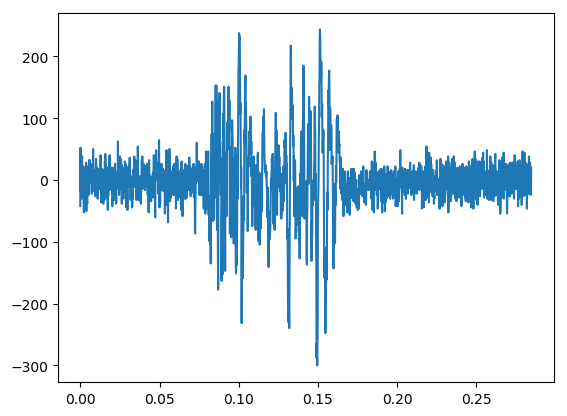

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f345c1e34a8>

In [26]:
plot(rangotiempos,lfprawsel)

In [27]:
1/tmax # la minima frecuencia observable.

3.5127854920187214

Por cada tipo de array, solo es necesario calcular el plan una vez. Asi que si el usuario cambia de electrodo, no es necesario volver a calcular el plan, pero si cambia la longitud entonces si.

In [28]:
plan=plan_fft(lfprawsel,  flags=FFTW.MEASURE)

FFTW forward plan for 1999-element array of Complex{Float64}
(dft-bluestein-1999/4000
  (dft-buffered-4000/1-0
    (dft-ct-dit/20
      (dftw-direct-20/16 "t3fv_20_avx2")
      (dft-vrank>=1-x20/1
        (dft-ct-dit/20
          (dftw-direct-20/152 "t2fv_20_avx2")
          (dft-direct-10-x20 "n1fv_10_avx2"))))
    (dft-r2hc-1
      (rdft-rank0-memcpy/8000))
    (dft-nop)))

Aplicamos la transformada númerica de Fourier ahora si. El plan se aplica con " * " en julia. Lo simetrizamos, y calculamos el poder (el valor absoluto al cuadrado)

In [29]:
fttotal=(plan*lfprawsel);
ftsym=circshift(fttotal, div(nmax,2));
epoder=map(abs2, ftsym);

Finalmente la prueba: una hermosa gráfica del espectro de poder por frecuencia. Descomentando las funciones de escala (xscale, yscale) podemos obtener representaciones logarítmicas.

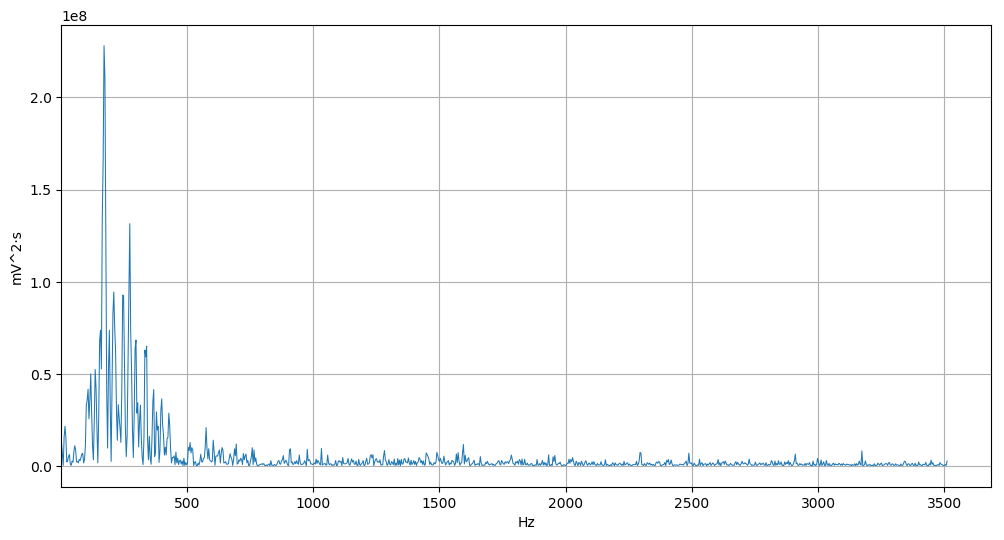

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f345c13d710>

In [30]:
figura=figure(figsize=(12,6))
grid(which="both")
fminplot=(1/tmax*0.95)
fmaxplot=freq/2*1.05
xlim(fminplot,fmaxplot)
xlabel(funits)
ylabel(punits)
#yscale("log")
#xscale("log")
#yscale("log")
mediorango=1:500
plot(rfreqsim,epoder, lw=0.74)
#outname=palabra*"-sweep_$nsweep.png"
#savefig(outname,dpi=90)

## Filtros por banda

Las bandas mas importantes en electrofisiología son:
* delta => de aprox. 0 a 3.5 Hz
* theta => de 3.5 a 7 Hz
* alfa => de 7 a 14 Hz
* beta => de 14 a 35 Hz
* gamma => de 35 a 100Hz
* sharp wave => de 100 a 250 Hz
* ultra sharp wave => de 250 a 600 Hz.

Hacer un filtro rígido es tán fácil como suprimir la parte del espectro fuera del rango interesante. Aqui definimos unas funciones auxiliares por conveniencia. La función genérica se encuentra en el modulo FFTWtoolkit.jl. Las funciones auxiliares se pueden ajustar a conveniencia del usuario y de los datos. ¡Las funciones se aplican sobre la transformada de Fourier sin simetrizar!

In [35]:
fdelta(datos)=filtrobanda(rangofreqs,datos, 0.1, 3.5)
ftheta(datos)=filtrobanda(rangofreqs, datos, 3.5, 7.022) # notese que estamos ajustando a la precisión. 
falpha(datos)=filtrobanda(rangofreqs, datos, 7.022, 14.044)
fbeta(datos)=filtrobanda(rangofreqs, datos, 14.044, 35.120)
fgamma(datos)=filtrobanda(rangofreqs, datos, 35.120, 100.0)
fspr(datos)=filtrobanda(rangofreqs, datos, 100.0, 250.0)
fuspr(datos)=filtrobanda(rangofreqs, datos, 250.0, 600.0)

fuspr (generic function with 1 method)

In [37]:
fftfgamma=fgamma(fttotal);


Probemos como se ve la señal filtrada. Hacemos el plan de la Transformada inversa primero, y luego se lo aplicamos (mismas concideraciones que el plan anterior).

In [38]:
planinverso=plan_ifft(fftfgamma, flags=FFTW.MEASURE)

0.0005002501250625312 * FFTW backward plan for 1999-element array of Complex{Float64}
(dft-bluestein-1999/4000
  (dft-buffered-4000/1-0
    (dft-ct-dit/20
      (dftw-direct-20/16 "t3fv_20_avx2")
      (dft-vrank>=1-x20/1
        (dft-ct-dit/20
          (dftw-direct-20/152 "t2fv_20_avx2")
          (dft-direct-10-x20 "n1fv_10_avx2"))))
    (dft-r2hc-1
      (rdft-rank0-memcpy/8000))
    (dft-nop)))

In [43]:
filtrada=planinverso*fftfgamma;  # quedan pequeños errores imaginarios asi que se los cortamos.
filtrada=real(filtrada);

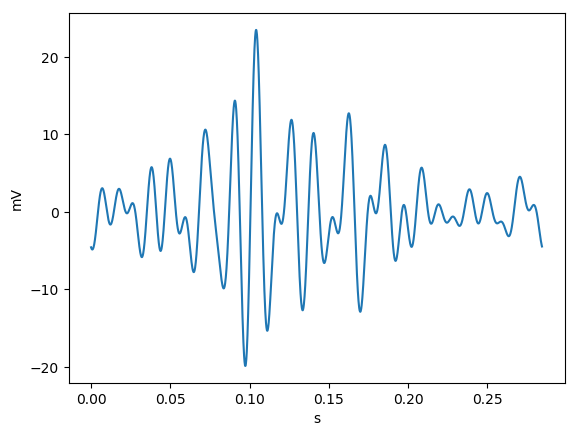

PyObject Text(24.000000000000007, 0.5, 'mV')

In [45]:
plot(rangotiempos, filtrada)
xlabel(tunits)
ylabel(vunits)

Observese que se pierde mucho poder, porque falta gran parte de la energía que esta sobre otras bandas.